# Integrated Simulations

In [1]:
import os; from os import listdir; from os.path import isfile, join
import re  
#from skimage import io 
from skimage.io import imread
# To manipulate arrays
import numpy as np 
import random
from tqdm.notebook import tqdm
from timeit import default_timer as timer
import scipy
import pandas as pd
import shutil
import pathlib
import sys
from skimage.exposure import rescale_intensity
import rsnapsim as rss
from skimage.measure import find_contours
# Plotting
import matplotlib as mpl ; import matplotlib.pyplot as plt 
# To create interactive elements
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout ; from IPython.display import Image

import dna_features_viewer
from dna_features_viewer import BiopythonTranslator, GraphicFeature, GraphicRecord, CircularGraphicRecord

In [2]:
# Deffining directories
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[1].joinpath('DataBases','gene_files')
video_dir = current_dir.parents[1].joinpath('DataBases','videos_for_sim_cell')
#trajectories_dir = current_dir.parents[1].joinpath('DataBases','rsnapsim_simulations','bactin_ssa.npy')
trajectories_dir = current_dir.parents[1].joinpath('DataBases','rsnapsim_simulations','kdm5b_ssa.npy')
rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')
gene_file = current_dir.parents[1].joinpath('DataBases','gene_files','KDM5B_withTags.txt')

In [3]:
# Paths to dropbox
from sys import platform as _platform
if _platform == "linux" or _platform == "linux2":
    dropbox_address = pathlib.Path('/','home','luisub','Dropbox', 'Project_rSNAPed','manuscript','Figures')
elif _platform == "darwin":
    dropbox_address = pathlib.Path('/','Users','luisaguilera','Dropbox', 'Project_rSNAPed','manuscript','Figures')

In [4]:
# Importing rSNAPed
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp

In [5]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.grid'] = False

In [6]:
from dna_features_viewer import BiopythonTranslator
class MyCustomTranslator(BiopythonTranslator):
    """Custom translator
    """
    def compute_feature_color(self, feature):
        if feature.type == "CDS":
            return "#57B956"
        elif feature.type == "FLAG":
            return "#ff0000"
        elif feature.type == "MS2":
            return "#098BF5"
        elif feature.type == "PP7": 
            return "#EB5559"
        else:
            return "#C4B07B"

In [7]:
# Plasmid sequences
'''
gene_file_pUB_SM_KDM5B_PP7 = str(sequences_dir.joinpath('kdm5b.gb')) # plasmid pUB_SM_KDM5B_PP7 

graphic_record = MyCustomTranslator().translate_record(gene_file_pUB_SM_KDM5B_PP7) 
ax, _ = graphic_record.plot(figure_width=20, strand_in_label_threshold=7)
#ax.set_title('pUB_SM_KDM5B_PP7 (1895 codons)')
graphic_record.plot_legend(ax=ax, loc=1, ncol=3, frameon=False)

name_figure = 'sequence.png'
figure_directory = str(dropbox_address.joinpath(name_figure ) )

ax.figure.savefig(figure_directory)
'''

"\ngene_file_pUB_SM_KDM5B_PP7 = str(sequences_dir.joinpath('kdm5b.gb')) # plasmid pUB_SM_KDM5B_PP7 \n\ngraphic_record = MyCustomTranslator().translate_record(gene_file_pUB_SM_KDM5B_PP7) \nax, _ = graphic_record.plot(figure_width=20, strand_in_label_threshold=7)\n#ax.set_title('pUB_SM_KDM5B_PP7 (1895 codons)')\ngraphic_record.plot_legend(ax=ax, loc=1, ncol=3, frameon=False)\n\nname_figure = 'sequence.png'\nfigure_directory = str(dropbox_address.joinpath(name_figure ) )\n\nax.figure.savefig(figure_directory)\n"

In [8]:
plt.style.use('ggplot')

In [9]:
fig_size = (2.5, 2.5)

In [10]:
# These are the parameters that need to be tested. 
number_of_simulated_cells = 1 # PLEASE TEST MIN 1 MAX 10
number_spots_per_cell = 100     # PLEASE TEST MIN 5 MAX 200
simulation_time_in_sec = 301     # PLEASE TEST MIN 10 MAX 100
diffusion_coefficient = 0.7    # PLEASE TEST MIN 0.1 MAX 2

In [11]:
intensity_calculation_method = 'disk_donut'  # options are : 'total_intensity' and 'disk_donut' 'gaussian_fit'
mask_selection_method = 'max_area' # options are : 'max_spots' and 'max_area' 
use_optimization_for_tracking = 1 # 0 not using, 1 is using optimization
frame_selection_empty_video = 'shuffle' # Options are: 'constant' , 'shuffle' and 'loop'

In [12]:
particle_size = 7 # spot size for the simulation and tracking.
elongation_rate = 10
initiation_rate = 0.03
inhibitor_time = 50

In [13]:
intensity_scale_ch0 = 100
intensity_scale_ch1 = 200
intensity_scale_ch2 = 200

In [14]:
particle_detection_size = particle_size

In [15]:
def rsnapsim_ssa(gene_file,ke,ki,frames=300,frame_rate=1,n_traj=20,inhibitor_time=None):
    '''
    This function uses rsnapsim to simulate the single-molecule translation dynamcis of any gene.
    Inputs:
    gene_file : str, with the location of a fasta file.
    ke : float, elongation rate.
    ki: float, initiation rate.
    frames: int, total number of simulation frames in seconds.
    n_traj: int, number of trajectories to simulate
    frame_rate : int, frame rate per second
    Outputs:
    ssa_int : NumPy array with dimenssions [Time_points, simulated_trajectories]
    '''
    poi_strs, poi_objs, tagged_pois,raw_seq = rss.seqmanip.open_seq_file(str(gene_file))
    gene_obj = tagged_pois['1'][0]
    gene_obj.ke_mu = ke
    rss.solver.protein = gene_obj #pass the protein object
    t_burnin = 1000
    t = np.linspace(0,t_burnin+frames,(t_burnin+frames+1)*(frame_rate))
    number_probes = np.amax(gene_obj.probe_vec)
    ssa_solution = rss.solver.solve_ssa(gene_obj.kelong,t,perturb=[0,1,t_burnin+inhibitor_time, 0],ki=ki, low_memory=True, n_traj=n_traj )
    ssa =  np.transpose( ssa_solution.intensity_vec[0,t_burnin*frame_rate:-1,:]) 
    ssa_ump = ssa/number_probes
    return ssa, ssa_ump, gene_obj, t,number_probes

## Running the simulations

In [16]:
def fun_simulated_cells(current_dir, video_dir,ke=3,ki=0.03,gene_file =None, trajectories_dir=None, number_of_simulated_cells=3,number_spots_per_cell=80,simulation_time_in_sec =100,step_size_in_sec=1,particle_size=5, diffusion_coefficient =1,path_to_rSNAPsim= None, path_to_save_output='temp',intensity_calculation_method='gaussian_fit',frame_selection_empty_video=frame_selection_empty_video,inhibitor_time=inhibitor_time):
    spot_size = particle_size
    spot_sigma = 1
    # Code that creates the folder to store results.
    diffusion_coefficient_string = str(diffusion_coefficient).replace('.','_')
    directory_name = 'Simulation_V2__'+'ns_'+str(number_spots_per_cell) +'_diff_'+ diffusion_coefficient_string 
    path_to_save_output = 'temp'
    save_to_path =  current_dir.joinpath(path_to_save_output , directory_name )
    if not os.path.exists(str(save_to_path)):
        os.makedirs(str(save_to_path))
    else:
        shutil.rmtree(str(save_to_path))
        os.makedirs(str(save_to_path))
    counter = 0
    ## Main loop that creates each cell and dataframe
    for cell_number in range (0, number_of_simulated_cells):
        output_directory_name = str(video_dir)
        list_files_names = sorted([f for f in listdir(output_directory_name) if isfile(join(output_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
        list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
        path_files = [ str(video_dir.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
        
        selected_video = 4
        
        video_path = path_files[selected_video]        
        video = imread(video_path) 

        # Reducing in a half the intensity in the original video
        video = video//2

        empty_videos = video
        
        counter +=1
        if counter>=len(path_files):
            counter =0
        if not (trajectories_dir is None ):
            # Loading trajectories from file
            ssa_trajectories = np.load(str(trajectories_dir))
            random_index_ch0 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
            random_index_ch1 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
            random_index_ch2 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
            simulated_trajectories_ch0 = ssa_trajectories[random_index_ch0,0:simulation_time_in_sec:step_size_in_sec]
            simulated_trajectories_ch1 = ssa_trajectories[random_index_ch1,0:simulation_time_in_sec:step_size_in_sec]
            simulated_trajectories_ch2 =  ssa_trajectories[random_index_ch2,0:simulation_time_in_sec:step_size_in_sec]
        else:
            # Simulations for intensity
            ssa1,ssa1_ump,_,_,number_probes = rsnapsim_ssa(gene_file,ke,ki,frames=simulation_time_in_sec,frame_rate=1,n_traj=number_spots_per_cell,inhibitor_time=inhibitor_time) # rss.ssa_solver(n_traj = number_spots_per_cell, start_time=starting_time,tf=starting_time+n_frames, tstep=starting_time+n_frames,k_elong_mean=3, k_initiation=.03)  # tstep = total number of steps including the burnin time 
            simulated_trajectories_ch1 = ssa1_ump
            ssa2,ssa2_ump,_,_,number_probes =  rsnapsim_ssa(gene_file,ke,ki,frames=simulation_time_in_sec,frame_rate=1,n_traj=number_spots_per_cell,inhibitor_time=inhibitor_time) # rss.ssa_solver(n_traj = number_spots_per_cell, start_time=starting_time,tf=starting_time+n_frames, tstep=starting_time+n_frames,k_elong_mean=3, k_initiation=.03)  # tstep = total number of steps including the burnin time 
            simulated_trajectories_ch2 = ssa2_ump
            simulated_trajectories_ch0 = simulated_trajectories_ch1
        #simulated_trajectories_ch0 = None
        # Running the cell simulation
        saved_file_name = str(save_to_path.joinpath('sim_cell_'+str(cell_number)))
        tensor_video , spot_positions_movement, DataFrame_particles_intensities = rsp.SimulatedCell( base_video=video, number_spots = number_spots_per_cell, number_frames=simulation_time_in_sec, step_size=step_size_in_sec, diffusion_coefficient =diffusion_coefficient, simulated_trajectories_ch0=simulated_trajectories_ch0, size_spot_ch0=spot_size, spot_sigma_ch0=spot_sigma, simulated_trajectories_ch1=simulated_trajectories_ch1, size_spot_ch1=spot_size, spot_sigma_ch1=spot_sigma, simulated_trajectories_ch2=simulated_trajectories_ch2, size_spot_ch2=spot_size, spot_sigma_ch2=spot_sigma, ignore_ch0=0,ignore_ch1=0, ignore_ch2=1,save_as_tif_uint8=0,save_as_tif =1,save_as_gif=0, save_dataframe=1, saved_file_name=saved_file_name,create_temp_folder = False, intensity_calculation_method=intensity_calculation_method,perform_video_augmentation=0,frame_selection_empty_video=frame_selection_empty_video ,intensity_scale_ch0 = intensity_scale_ch0,intensity_scale_ch1 = intensity_scale_ch1,intensity_scale_ch2 = intensity_scale_ch2).make_simulation()      
        #print ('The results are saved in folder: ', saved_file_name)
    return save_to_path, simulated_trajectories_ch0, simulated_trajectories_ch1, simulated_trajectories_ch2, empty_videos

In [17]:
# running the simulation
start = timer()
output_directory_name, simulated_trajectories_ch0, simulated_trajectories_ch1, simulated_trajectories_ch2, empty_videos = fun_simulated_cells(current_dir,video_dir,ke=elongation_rate, ki=initiation_rate,trajectories_dir=None,gene_file= gene_file, number_of_simulated_cells=number_of_simulated_cells,number_spots_per_cell=number_spots_per_cell,simulation_time_in_sec =simulation_time_in_sec,step_size_in_sec=1,particle_size=particle_size, diffusion_coefficient=diffusion_coefficient,path_to_rSNAPsim= None,intensity_calculation_method=intensity_calculation_method,frame_selection_empty_video=frame_selection_empty_video,inhibitor_time=inhibitor_time)
end = timer()
print('Time to generate simulated data:',round(end - start), ' sec')

Time to generate simulated data: 34  sec


In [18]:
output_directory_name

PosixPath('/home/luisub/Desktop/rsnaped/notebooks/Paper_Figures/temp/Simulation_V2__ns_100_diff_0_7')

In [19]:
# Reads the folder with the results and import the simulations as lists
list_files_names = sorted([f for f in listdir(output_directory_name) if isfile(join(output_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files = [ str(output_directory_name.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file

# Reading the microscopy data
list_videos_original = [imread(f)[:,:,:,:] for f in  path_files] # List with all the videos
nimg = number_of_simulated_cells

In [20]:
# Rescaling images
rescale_video = False
if rescale_video == True:
    list_videos = []
    number_channels = list_videos_original[0].shape[-1]
    number_z_slices = list_videos_original[0].shape[0]
    for i in range (0,nimg ):
        temp_img = np.zeros_like(list_videos_original[0])
        for j in range(0,number_channels):
            temp_img[:,:,:,j] =  np.asarray( [ rescale_intensity(list_videos_original[i][z,:,:,j], in_range='image', out_range='dtype')  for z in range (0, number_z_slices)]  )
        list_videos.append(temp_img)
else:
    list_videos = list_videos_original

## Display results as images

In [21]:
def df_to_array(dataframe_simulated_cell):
    '''
    This function takes the dataframe and extracts the information from it. 
    Information is separated by particles. Notice that dataframe contains information about 600 particles.

    Input
        dataframe_simulated_cell : pandas dataframe

    Returns
        I_g : Intensities for each particle in the green channel. NumPy array with dimensions [number_particles, time_points]
        I_g_std : Std for the intensities for each particle in the green channel.  NumPy array with dimensions [number_particles, time_points]
        I_r : Intensities for each particle in the red channel. NumPy array with dimensions [number_particles, time_points]
        I_r_std : Std for the intensities for each particle in the red channel. NumPy array with dimensions [number_particles, time_points]
        x_loc : x position for each particle in the dataframe. NumPy array with dimensions [number_particles, time_points]
        y_loc : y position for each particle in the dataframe. NumPy array with dimensions [number_particles, time_points]
  
    '''
    # get the total number of particles in all cells
    total_particles = 0
    for cell in set(dataframe_simulated_cell['cell_number']):
        total_particles += len(set(dataframe_simulated_cell[dataframe_simulated_cell['cell_number'] == 0]['particle'] ))

    #preallocate numpy array sof n_particles by nframes
    I_g = np.zeros([total_particles, np.max(dataframe_simulated_cell['frame'])+1] )  #intensity green
    I_g_std = np.zeros([total_particles, np.max(dataframe_simulated_cell['frame'])+1] ) #intensity green std
    x_loc = np.zeros([total_particles, np.max(dataframe_simulated_cell['frame'])+1] ) #x loc
    y_loc = np.zeros([total_particles, np.max(dataframe_simulated_cell['frame'])+1] ) #y_loc
    I_r_std   = np.zeros([total_particles, (np.max(dataframe_simulated_cell['frame'])+1)] ) #intensity red
    I_r = np.zeros([total_particles, (np.max(dataframe_simulated_cell['frame'])+1) ] ) #intensity red std
    k = 0

    # For loops that iterate for each particle and stores the data in the previously pre-alocated arrays.
    for cell in set(dataframe_simulated_cell['cell_number']):  #for every cell 
        for particle in set(dataframe_simulated_cell[dataframe_simulated_cell['cell_number'] == 0]['particle'] ): #for every particle
            tmpdf = dataframe_simulated_cell[(dataframe_simulated_cell['cell_number'] == cell) & (dataframe_simulated_cell['particle'] == particle)]  #slice the dataframe
            maxframe = np.max(tmpdf['frame'])
            minframe = np.min(tmpdf['frame'])
            I_g[k, 0:(maxframe+1-minframe)] = tmpdf['green_int_mean']  #fill the arrays to return out
            x_loc[k, 0:(maxframe+1-minframe)] = tmpdf['x']
            y_loc[k, 0:(maxframe+1-minframe)] = tmpdf['y']
            I_g_std[k, 0:(maxframe+1-minframe)] = tmpdf['green_int_std']
            I_r[k, 0:(maxframe+1-minframe)] = tmpdf['red_int_mean']
            I_r_std[k, 0:(maxframe+1-minframe)] = tmpdf['red_int_std']
            k+=1 #iterate over k (total particles)
    return I_g, I_g_std, I_r, I_r_std, x_loc,y_loc   #return everything backout

In [22]:
# Reads the folder with the results and import the simulations as lists
list_files_names = sorted([f for f in listdir(output_directory_name) if isfile(join(output_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files = [ str(output_directory_name.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file

# Reading the microscopy data
list_videos_original = [imread(f)[:,:,:,:] for f in  path_files] # List with all the videos
nimg = number_of_simulated_cells

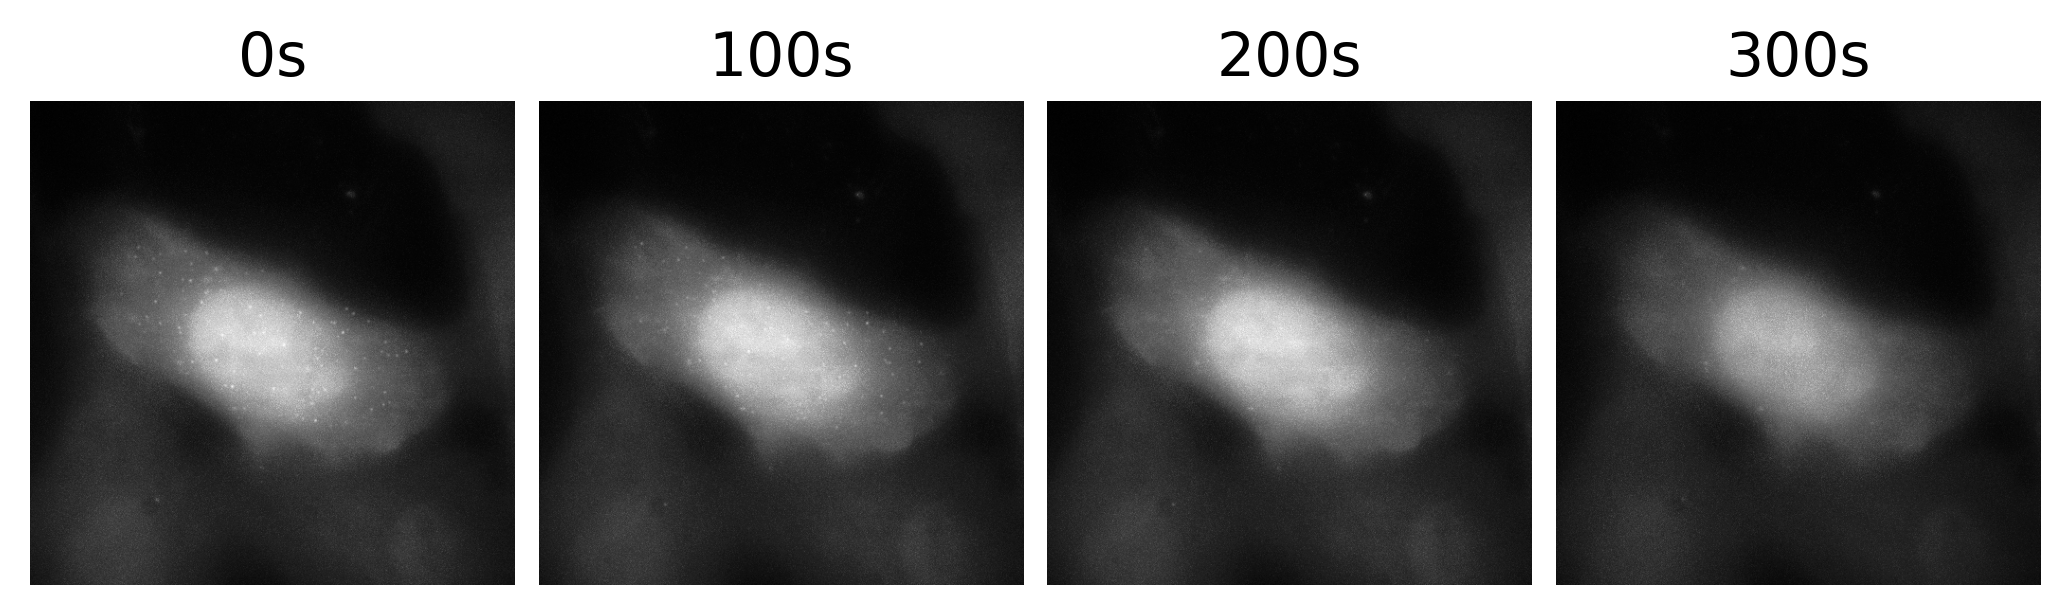

In [23]:
#ncrops = 4
#time_vector = np.round(np.linspace(0,simulation_time_in_sec-1,ncrops)).astype(int)

time_vector = [0, 100, 200, 300]
ncrops = len(time_vector)
time_vector
channel = 1
fig, axes = plt.subplots(nrows=1, ncols=ncrops, figsize=(7, 2))
max_val=[]
min_val=[]
for i in range(0, ncrops):
    temp_img= list_videos[0][time_vector[i],:,:,channel]
    max_val.append(np.amax(temp_img))
    min_val.append(np.amin(temp_img))# running the simulation

for i in range(0, ncrops):
    axes[i].imshow(list_videos[0][time_vector[i],:,:,channel],cmap='Greys_r', vmin=min(min_val), vmax=max(max_val))
    axes[i].axis('off')
    axes[i].set(title= str(time_vector[i]) + 's')
#axes[2].hist(SNR_b_flat,bins=60,density=True, stacked=True, color='cyan' )     
#axes[2].set(xlabel='intensities (au)')
#axes[2].set(ylabel='count')
name_figure = 'HT_cells.png'
figure_directory = str(dropbox_address.joinpath(name_figure ) )

plt.tight_layout() 
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig(figure_directory, transparent=True,dpi=300)
plt.show()

In [24]:
import matplotlib as mpl
label_size = 5
plt.style.use('default')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.grid'] = False

mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.linewidth'] = 0.5

In [25]:
sel_timepoint = 0 #simulation_time_in_sec-1

In [26]:
# running the simulation
start = timer()
output_directory_name, simulated_trajectories_ch0, simulated_trajectories_ch1, simulated_trajectories_ch2, empty_videos = fun_simulated_cells(current_dir,video_dir,ke=3, ki=0.03,trajectories_dir=None,gene_file= gene_file, number_of_simulated_cells=1,number_spots_per_cell=1,simulation_time_in_sec =simulation_time_in_sec,step_size_in_sec=1,particle_size=particle_size, diffusion_coefficient=diffusion_coefficient ,path_to_rSNAPsim= None,intensity_calculation_method=intensity_calculation_method,frame_selection_empty_video=frame_selection_empty_video,inhibitor_time=inhibitor_time)
end = timer()
print('Time to generate simulated data:',round(end - start), ' sec')
print(output_directory_name)

Time to generate simulated data: 6  sec
/home/luisub/Desktop/rsnaped/notebooks/Paper_Figures/temp/Simulation_V2__ns_1_diff_0_7


In [27]:
# Reads the folder with the results and import the simulations as lists
list_files_names = sorted([f for f in listdir(output_directory_name) if isfile(join(output_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files = [ str(output_directory_name.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
# Reading the microscopy data
list_videos_crops = [imread(f)[:,:,:,:] for f in  path_files] # List with all the videos


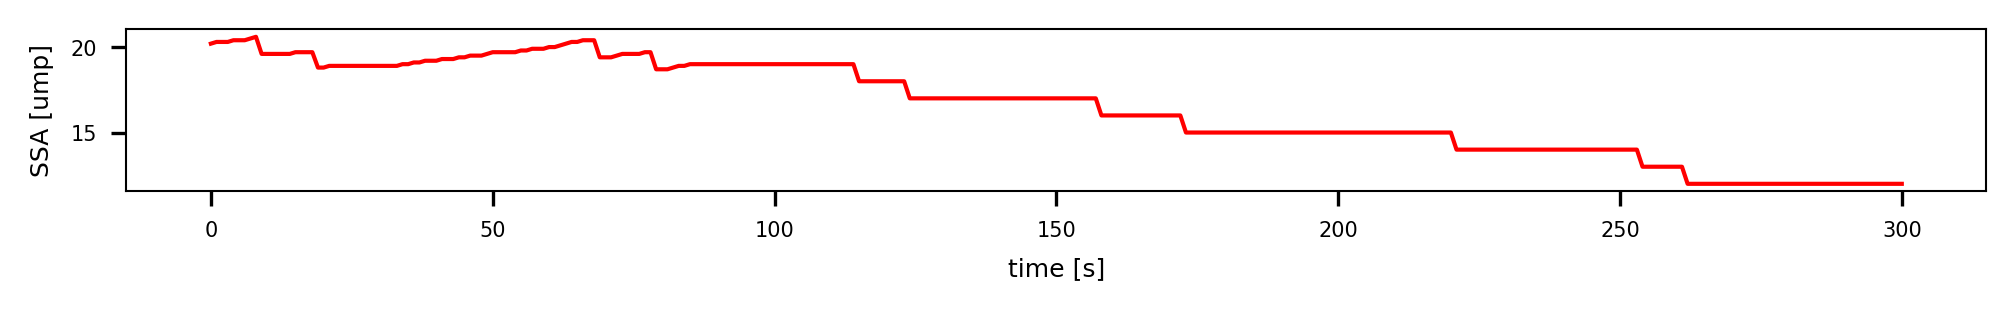

In [28]:
plt.figure(figsize=(8,0.7),dpi=300)
selected_trajectory = 0
plt.plot(simulated_trajectories_ch1[selected_trajectory,:],color='r')
name_figure = 'HT_SSA.png'
figure_directory = str(dropbox_address.joinpath(name_figure ) )
plt.ylabel('SSA [ump]', fontsize=6)
plt.xlabel('time [s]', fontsize=6)
plt.savefig(figure_directory, transparent=False,dpi=300, bbox_inches = "tight")
plt.show()

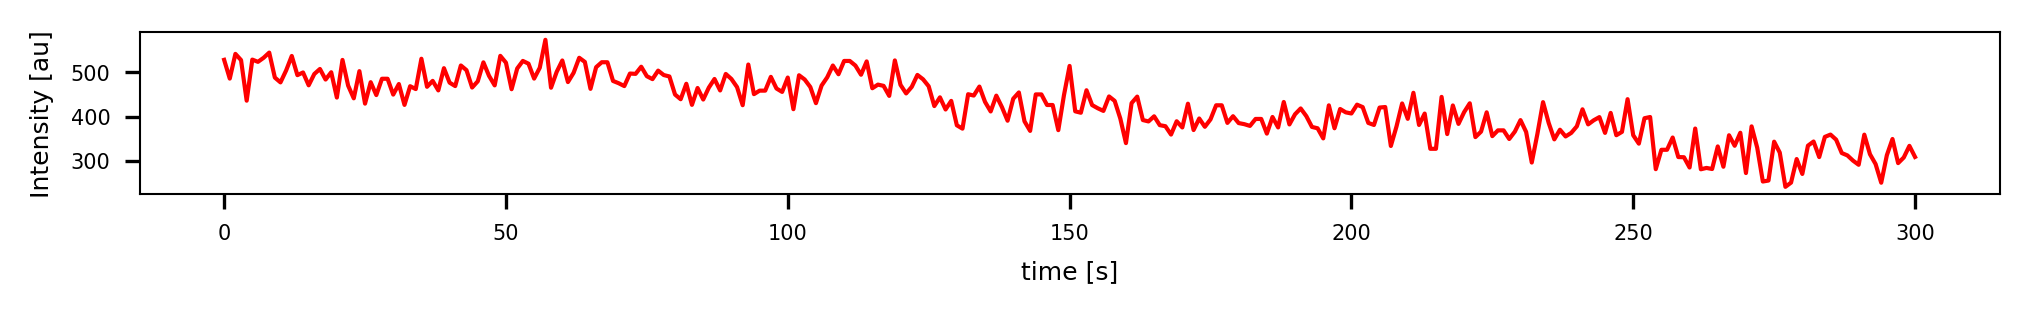

In [29]:
file_name = str(output_directory_name.joinpath('sim_cell_0_df.csv'))
df_intensities_real = pd.read_csv(file_name)  
intensity_values_in_image_trajectory = df_intensities_real[df_intensities_real['particle'] ==selected_trajectory].green_int_mean.values

plt.figure(figsize=(8,0.7),dpi=300)
plt.plot(intensity_values_in_image_trajectory,color='r')
name_figure = 'HT_SSA_in_cell.png'
figure_directory = str(dropbox_address.joinpath(name_figure ) )
plt.ylabel('Intensity [au]', fontsize=6)
plt.xlabel('time [s]', fontsize=6)
plt.savefig(figure_directory, transparent=False,dpi=300, bbox_inches = "tight")

In [30]:
ncrops = 30
print('Time to generate simulated data:',round(end - start), ' sec')
time_vector = np.round(np.linspace(0,simulation_time_in_sec-1,ncrops)).astype(int)
time_vector

Time to generate simulated data: 6  sec


array([  0,  10,  21,  31,  41,  52,  62,  72,  83,  93, 103, 114, 124,
       134, 145, 155, 166, 176, 186, 197, 207, 217, 228, 238, 248, 259,
       269, 279, 290, 300])

In [31]:
file_name = str(output_directory_name.joinpath('sim_cell_0_df.csv'))
df_intensities_real = pd.read_csv(file_name)  

In [32]:
I_g, I_g_std, I_r, I_r_std, x_loc,y_loc = df_to_array(df_intensities_real)

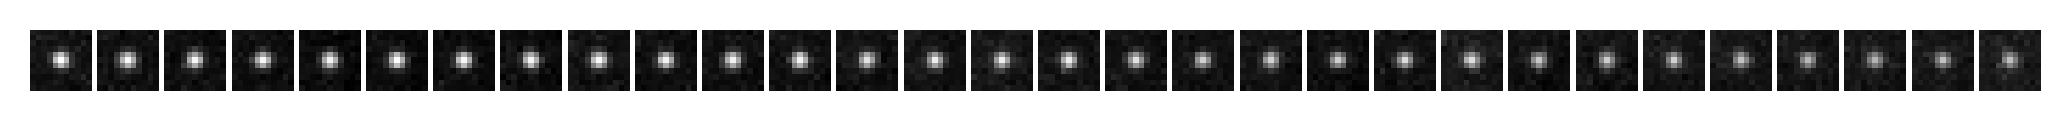

In [33]:
# plotting
channel = 0
fig, axes = plt.subplots(nrows=1, ncols=ncrops, figsize=(7, 2))
disk_size = 5
max_val=[]
min_val=[]
for i in range(0, ncrops):
    y_pos = y_loc[0, time_vector[i]].astype(int)
    x_pos = x_loc[0,time_vector[i] ].astype(int)
    crop_img= list_videos_crops[0][time_vector[i], y_pos-(disk_size): y_pos+(disk_size+1) , x_pos-(disk_size):x_pos+(disk_size+1),  channel ] 
    max_val.append(np.amax(crop_img))
    min_val.append(np.amin(crop_img))


for i in range(0, ncrops):
    y_pos = y_loc[0, time_vector[i]].astype(int)
    x_pos = x_loc[0,time_vector[i] ].astype(int)
    crop_img= list_videos_crops[0][time_vector[i], y_pos-(disk_size): y_pos+(disk_size+1) , x_pos-(disk_size):x_pos+(disk_size+1),  channel ] 

    axes[i].imshow(crop_img,cmap='Greys_r', vmin=min(min_val), vmax=max(max_val))
    axes[i].axis('off')

#axes[2].hist(SNR_b_flat,bins=60,density=True, stacked=True, color='cyan' )     
#axes[2].set(title='Image')
#axes[2].set(xlabel='intensities (au)')
#axes[2].set(ylabel='count')
name_figure = 'HT_crops.png'
figure_directory = str(dropbox_address.joinpath(name_figure ) )

plt.tight_layout() 
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.savefig(figure_directory, transparent=True,dpi=300)
plt.show()